<a href="https://colab.research.google.com/github/AntonDozhdikov/RL_OTUS_Learn/blob/main/DynaQ_Qagent_Frozen_lake_8_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Установка необходимых пакетов для Google Colab.
!pip install gymnasium==0.29.1
!pip install pygame==2.5.0

# Эта сборка самая стабильная и не требует лишней допки, если не лезть в графику и визуализацию
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


In [2]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cuda


In [3]:
# Создание класса для моделирования стохастической среды с использованием PyTorch
class StochasticFrozenLakeModel(nn.Module):
    def __init__(self, num_states=64, num_actions=4):  # Инициализация класса с параметрами
        super().__init__()  # Вызов конструктора базового класса
        self.num_states = num_states  # Сохранение количества состояний
        self.num_actions = num_actions  # Сохранение количества действий

        # Тензоры для хранения переходов и наград
        self.transitions = torch.zeros((num_states, num_actions, num_states), device=device)  # Тензор переходов: [состояние, действие, следующее состояние]
        self.rewards = torch.zeros((num_states, num_actions, num_states), device=device)  # Тензор наград: [состояние, действие, следующее состояние]
        self.state_action_counts = torch.zeros((num_states, num_actions), device=device)  # Тензор для подсчета количества посещений каждой пары (состояние, действие)
        self.history = []  # Список для хранения истории состояний и действий

    def update(self, state, action, next_state, reward):  # Метод обновления модели
        self.transitions[state, action, next_state] += 1  # Обновление тензора переходов
        self.rewards[state, action, next_state] = reward  # Обновление тензора наград
        self.state_action_counts[state, action] += 1  # Обновление тензора подсчета посещений
        self.history.append((state, action))  # Добавление текущей пары (state, action) в историю

    def sample(self):  # Метод для случайного выбора состояния и действия из истории
        if len(self.history) == 0:  # Проверка, есть ли в истории состояния и действия
            return None, None  # Если история пуста, возвращаем None
        idx = np.random.randint(0, len(self.history))  # Случайный выбор индекса из истории
        return self.history[idx]  # Возвращение случайно выбранного состояния и действия из истории

    def get_next_state_and_reward(self, state, action):  # Метод для получения следующего состояния и награды
        probs = self.transitions[state, action] / self.transitions[state, action].sum()  # Вычисление вероятностей переходов
        m = torch.distributions.Categorical(probs)  # Создание распределения Categorical на основе вычисленных вероятностей
        next_state = m.sample()  # Выбор следующего состояния на основе распределения
        reward = self.rewards[state, action, next_state]  # Получение награды за переход в следующее состояние
        return next_state.item(), reward.item()  # Возвращение следующего состояния и награды в виде целых чисел

In [4]:
# Реализация агента Dyna-Q с нейронной сетью
class DynaQAgent:
    def __init__(self, env, alpha=0.001, gamma=0.95, epsilon=0.1, planning_steps=5):  # Инициализация агента с параметрами
        self.env = env  # Окружение для обучения
        self.alpha = alpha  # Скорость обучения
        self.gamma = gamma  # Коэффициент дисконтирования
        self.epsilon = epsilon  # Вероятность случайного действия (epsilon-greedy)
        self.planning_steps = planning_steps  # Количество шагов планирования

        # Q-сеть: нейронная сеть для аппроксимации функции Q
        self.q_net = nn.Sequential(  # Последовательная модель
            nn.Linear(1, 64),  # Полносвязный слой с 1 входом и 64 выходами
            nn.ReLU(),  # Функция активации ReLU
            nn.Linear(64, env.action_space.n)  # Полносвязный слой с 64 входами и количеством выходов, равным количеству действий
        ).to(device)  # Перемещение сети на выбранное устройство (GPU или CPU)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=alpha)  # Оптимизатор Adam для обучения Q-сети
        self.model = StochasticFrozenLakeModel().to(device)  # Модель среды для планирования

    def choose_action(self, state):  # Метод для выбора действия на основе текущего состояния
        if np.random.uniform(0, 1) < self.epsilon:  # С вероятностью epsilon выбираем случайное действие
            return self.env.action_space.sample()  # Выбор случайного действия из пространства действий
        else:
            with torch.no_grad():  # Отключаем градиенты для ускорения вычислений
                q_values = self.q_net(torch.tensor([[state]], dtype=torch.float32).to(device))  # Получение Q-значений для текущего состояния
                return q_values.argmax().item()  # Выбор действия с максимальным Q-значением

    def learn(self, state, action, reward, next_state, done):  # Метод обучения агента
        # Обновление Q-сети
        state_tensor = torch.tensor([[state]], dtype=torch.float32).to(device)  # Преобразование состояния в тензор
        next_state_tensor = torch.tensor([[next_state]], dtype=torch.float32).to(device)  # Преобразование следующего состояния в тензор
        reward_tensor = torch.tensor(reward, dtype=torch.float32).to(device)  # Преобразование награды в тензор

        q_value = self.q_net(state_tensor)[0, action]  # Получение текущего Q-значения для выбранного действия
        next_q_value = self.q_net(next_state_tensor).max() if not done else torch.tensor(0.0, device=device)  # Получение максимального Q-значения для следующего состояния

        target = reward_tensor + self.gamma * next_q_value  # Вычисление целевой Q-значения
        loss = (q_value - target)**2  # Вычисление ошибки (квадрат разности)

        self.optimizer.zero_grad()  # Сброс градиентов
        loss.backward()  # Обратное распространение ошибки
        self.optimizer.step()  # Обновление параметров сети

        # Обновление модели среды
        self.model.update(state, action, next_state, reward)  # Обновление модели на основе реального опыта

        # Планирование
        for _ in range(self.planning_steps):  # Выполнение нескольких шагов планирования
            s, a = self.model.sample()  # Выбор случайного состояния и действия из истории
            if s is None:  # Если история пуста, пропускаем шаг
                continue

            s_next, r = self.model.get_next_state_and_reward(s, a)  # Получение следующего состояния и награды из модели

            state_tensor = torch.tensor([[s]], dtype=torch.float32).to(device)  # Преобразование состояния в тензор
            next_state_tensor = torch.tensor([[s_next]], dtype=torch.float32).to(device)  # Преобразование следующего состояния в тензор
            reward_tensor = torch.tensor(r, dtype=torch.float32).to(device)  # Преобразование награды в тензор

            q_value = self.q_net(state_tensor)[0, a]  # Получение текущего Q-значения для выбранного действия
            next_q_value = self.q_net(next_state_tensor).max()  # Получение максимального Q-значения для следующего состояния

            target = reward_tensor + self.gamma * next_q_value  # Вычисление целевой Q-значения
            loss = (q_value - target)**2  # Вычисление ошибки (квадрат разности)

            self.optimizer.zero_grad()  # Сброс градиентов
            loss.backward()  # Обратное распространение ошибки
            self.optimizer.step()  # Обновление параметров сети

            # Обновление модели среды
            self.model.update(state, action, next_state, reward)  # Обновление модели на основе реального опыта

            # Планирование
            for _ in range(self.planning_steps):  # Выполнение нескольких шагов планирования
                s, a = self.model.sample()  # Выбор случайного состояния и действия из истории
                if s is None:  # Если история пуста, пропускаем шаг
                    continue

                s_next, r = self.model.get_next_state_and_reward(s, a)  # Получение следующего состояния и награды из модели

                state_tensor = torch.tensor([[s]], dtype=torch.float32).to(device)  # Преобразование состояния в тензор
                next_state_tensor = torch.tensor([[s_next]], dtype=torch.float32).to(device)  # Преобразование следующего состояния в тензор
                reward_tensor = torch.tensor(r, dtype=torch.float32).to(device)  # Преобразование награды в тензор

                q_value = self.q_net(state_tensor)[0, a]  # Получение текущего Q-значения для выбранного действия
                next_q_value = self.q_net(next_state_tensor).max()  # Получение максимального Q-значения для следующего состояния

                target = reward_tensor + self.gamma * next_q_value  # Вычисление целевой Q-значения
                loss = (q_value - target)**2  # Вычисление ошибки (квадрат разности)

                self.optimizer.zero_grad()  # Сброс градиентов
                loss.backward()  # Обратное распространение ошибки
                self.optimizer.step()  # Обновление параметров сети


In [5]:
# Реализация простого Q-агента с нейронной сетью
class QLearningAgent:
    def __init__(self, env, alpha=0.001, gamma=0.95, epsilon=0.1):  # Инициализация агента с параметрами
        self.env = env  # Окружение для обучения
        self.alpha = alpha  # Скорость обучения
        self.gamma = gamma  # Коэффициент дисконтирования
        self.epsilon = epsilon  # Вероятность случайного действия (epsilon-greedy)

        # Q-сеть: нейронная сеть для аппроксимации функции Q
        self.q_net = nn.Sequential(  # Последовательная модель
            nn.Linear(1, 64),  # Полносвязный слой с 1 входом и 64 выходами
            nn.ReLU(),  # Функция активации ReLU
            nn.Linear(64, env.action_space.n)  # Полносвязный слой с 64 входами и количеством выходов, равным количеству действий
        ).to(device)  # Перемещение сети на выбранное устройство (GPU или CPU)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=alpha)  # Оптимизатор Adam для обучения Q-сети

    def choose_action(self, state):  # Метод для выбора действия на основе текущего состояния
        if np.random.uniform(0, 1) < self.epsilon:  # С вероятностью epsilon выбираем случайное действие
            return self.env.action_space.sample()  # Выбор случайного действия из пространства действий
        else:
            with torch.no_grad():  # Отключаем градиенты для ускорения вычислений
                q_values = self.q_net(torch.tensor([[state]], dtype=torch.float32).to(device))  # Получение Q-значений для текущего состояния
                return q_values.argmax().item()  # Выбор действия с максимальным Q-значением

    def learn(self, state, action, reward, next_state, done):  # Метод обучения агента
        # Обновление Q-сети
        state_tensor = torch.tensor([[state]], dtype=torch.float32).to(device)  # Преобразование состояния в тензор
        next_state_tensor = torch.tensor([[next_state]], dtype=torch.float32).to(device)  # Преобразование следующего состояния в тензор
        reward_tensor = torch.tensor(reward, dtype=torch.float32).to(device)  # Преобразование награды в тензор

        q_value = self.q_net(state_tensor)[0, action]  # Получение текущего Q-значения для выбранного действия
        next_q_value = self.q_net(next_state_tensor).max() if not done else torch.tensor(0.0, device=device)  # Получение максимального Q-значения для следующего состояния

        target = reward_tensor + self.gamma * next_q_value  # Вычисление целевой Q-значения
        loss = (q_value - target)**2  # Вычисление ошибки (квадрат разности)

        self.optimizer.zero_grad()  # Сброс градиентов
        loss.backward()  # Обратное распространение ошибки
        self.optimizer.step()  # Обновление параметров сети


In [6]:
# Функция для обучения агентов с промежуточной печатью и сохранением моделей.
def train_agent(env, agent, episodes=50, model_name=None):
    rewards = []  # Список для хранения наград за каждый эпизод
    best_average_reward = -np.inf  # Начальное значение для лучшей средней награды

    # Открытие файла для записи логов
    log_file = open('training_log.txt', 'w')  # Создаем файл для записи логов

    for episode in range(episodes):  # Цикл по эпизодам
        state, _ = env.reset()  # Сброс окружения и получение начального состояния
        done = False  # Флаг завершения эпизода
        total_reward = 0  # Суммарная награда за эпизод

        while not done:  # Цикл выполнения шагов в эпизоде
            action = agent.choose_action(state)  # Выбор действия агентом
            next_state, reward, done, _, _ = env.step(action)  # Выполнение действия в окружении
            agent.learn(state, action, reward, next_state, done)  # Обучение агента
            state = next_state  # Обновление состояния
            total_reward += reward  # Накопление награды

        rewards.append(total_reward)  # Добавление награды за эпизод в список

        # Печать промежуточных результатов каждые 50 эпизодов.
        if (episode + 1) % 50 == 0:  # Проверка, является ли эпизод кратным 50
            average_reward = np.mean(rewards[-50:])  # Вычисление средней награды за последние 50 эпизодов
            print(f'Эпизод: {episode + 1}, Средняя награда за последние 50 эпизодов: {average_reward:.4f}')  # Вывод промежуточных результатов
            log_file.write(f'Эпизод: {episode + 1}, Средняя награда за последние 50 эпизодов: {average_reward:.4f}\n')  # Запись в файл логов

            # Сохранение модели если она лучше предыдущей.
            if average_reward > best_average_reward and model_name is not None:  # Проверка на улучшение средней награды
                best_average_reward = average_reward  # Обновление лучшей средней награды
                torch.save(agent.q_net.state_dict(), model_name)  # Сохранение модели
                print(f'Сохранена лучшая модель: {model_name}')  # Вывод сообщения о сохранении модели
                log_file.write(f'Сохранена лучшая модель: {model_name}\n')  # Запись в файл логов

    log_file.close()  # Закрытие файла логов
    return rewards  # Возвращение списка наград за все эпизоды


In [7]:
# Создание среды Frozen Lake 8x8.
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True)  # Создание среды Frozen Lake 8x8 с использованием OpenAI Gym

# Обучение Dyna-Q агента.
dyna_agent = DynaQAgent(env, planning_steps=5)  # Инициализация Dyna-Q агента с параметрами планирования
dyna_rewards = train_agent(env, dyna_agent, 1200, 'best_dyna_model.pth')  # Обучение Dyna-Q агента на 1200 эпизодов и сохранение лучшей модели

# Обучение обычного Q-агента.
q_agent = QLearningAgent(env)  # Инициализация обычного Q-агента
q_rewards = train_agent(env, q_agent, 1200, 'best_q_model.pth')  # Обучение обычного Q-агента на 1200 эпизодов и сохранение лучшей модели

Эпизод: 50, Средняя награда за последние 50 эпизодов: 0.0000
Сохранена лучшая модель: best_dyna_model.pth
Эпизод: 100, Средняя награда за последние 50 эпизодов: 0.0200
Сохранена лучшая модель: best_dyna_model.pth
Эпизод: 150, Средняя награда за последние 50 эпизодов: 0.0000
Эпизод: 200, Средняя награда за последние 50 эпизодов: 0.0000
Эпизод: 250, Средняя награда за последние 50 эпизодов: 0.0000
Эпизод: 300, Средняя награда за последние 50 эпизодов: 0.0400
Сохранена лучшая модель: best_dyna_model.pth
Эпизод: 350, Средняя награда за последние 50 эпизодов: 0.0200
Эпизод: 400, Средняя награда за последние 50 эпизодов: 0.0600
Сохранена лучшая модель: best_dyna_model.pth
Эпизод: 450, Средняя награда за последние 50 эпизодов: 0.1000
Сохранена лучшая модель: best_dyna_model.pth
Эпизод: 500, Средняя награда за последние 50 эпизодов: 0.0200
Эпизод: 550, Средняя награда за последние 50 эпизодов: 0.0400
Эпизод: 600, Средняя награда за последние 50 эпизодов: 0.0600
Эпизод: 650, Средняя награда за 

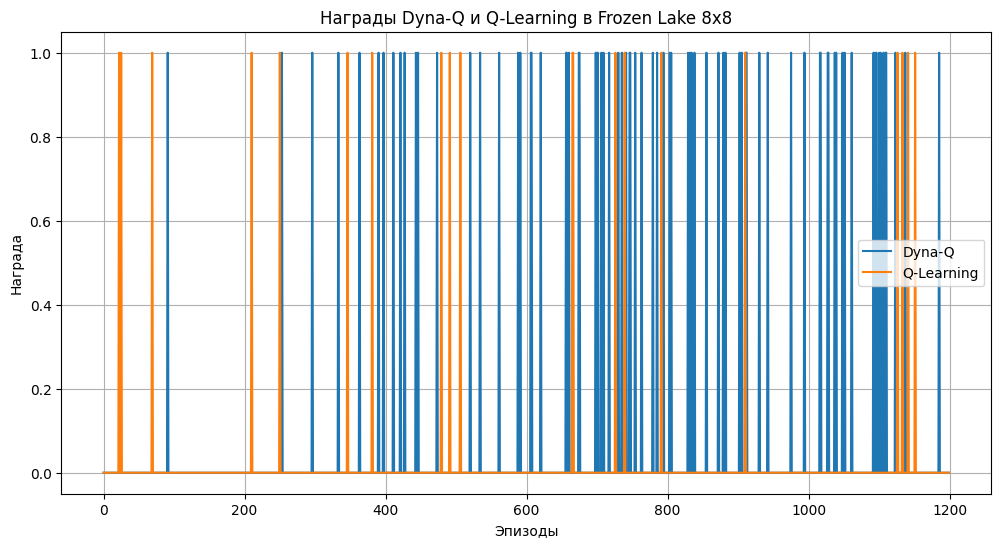

In [8]:
# Визуализация обычных результатов наград  линиями.
plt.figure(figsize=(12, 6))
plt.plot(dyna_rewards, label='Dyna-Q')
plt.plot(q_rewards, label='Q-Learning')
plt.xlabel('Эпизоды')
plt.ylabel('Награда')
plt.title('Награды Dyna-Q и Q-Learning в Frozen Lake 8x8')
plt.legend()
plt.grid(True)
plt.savefig('rewards_plot.png')
plt.show()

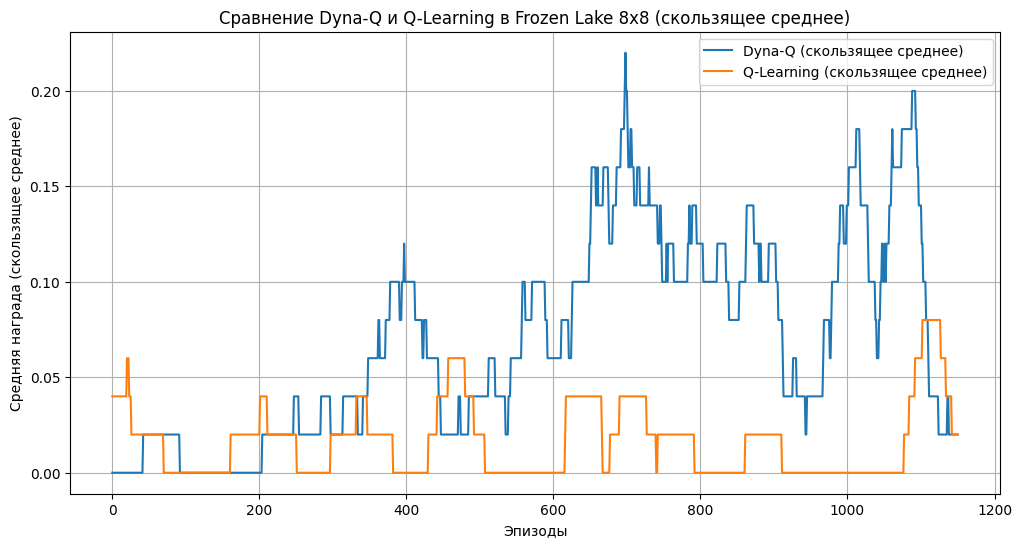

In [9]:
# Визуализация скользящего среднего результатов.
plt.figure(figsize=(12, 6))
plt.plot(np.convolve(dyna_rewards, np.ones(50)/50, mode='valid'), label='Dyna-Q (скользящее среднее)')
plt.plot(np.convolve(q_rewards, np.ones(50)/50, mode='valid'), label='Q-Learning (скользящее среднее)')
plt.xlabel('Эпизоды')
plt.ylabel('Средняя награда (скользящее среднее)')
plt.title('Сравнение Dyna-Q и Q-Learning в Frozen Lake 8x8 (скользящее среднее)')
plt.legend()
plt.grid(True)
plt.savefig('moving_average_plot.png')
plt.show()